#### Étape 1: Importation des bibliothèques nécessaires
Importez les modules requis pour PyTorch, les transformations, la visualisation, et les métriques, en alignant avec votre exemple initial

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

#### Étape 2: Initialisation des graines aléatoires pour la reproductibilité
Définissez une graine aléatoire pour garantir que les résultats soient reproductibles, en suivant votre exemple.

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Étape 3: Chargement du dataset et calcul des statistiques (mean/std)
Adaptez le chargement pour utiliser AMHCD au lieu de MNIST, et calculez la moyenne et l'écart-type pour la normalisation.

In [9]:
ROOT = '/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive /AMHCD_64'

# Charger le dataset AMHCD
train_data = datasets.ImageFolder(root=ROOT, transform=transforms.ToTensor())

# Calculer mean et std sur l'ensemble du dataset
data_array = torch.stack([img for img, _ in train_data])
mean = data_array.float().mean() / 255
std = data_array.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.0036593324039131403
Calculated std: 0.0005807935376651585


### Étapes suivantes
Étape 4: Définition des transformations et division du dataset
Définissez les transformations incluant la normalisation avec les valeurs calculées, et divisez en ensembles d'entraînement et de test.

In [19]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),  # Adapté pour AMHCD resized to 32x32, mais crop to 28 pour simuler MNIST size
    transforms.Resize((32, 32)),  # Redimensionnement pour LeNet-5
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

#### Étape 5: Chargement des datasets d'entraînement et de test
Chargez AMHCD avec les transformations adaptées (33 classes au lieu de 10 pour MNIST).

In [21]:
train_data = datasets.ImageFolder(root=ROOT, transform=train_transforms)
test_data = datasets.ImageFolder(root=ROOT, transform=test_transforms)  # Note: Pour AMHCD, utiliser un split au lieu de train=False

#### Étape 6: Création d'un ensemble de validation
Divisez l'ensemble d'entraînement pour créer un ensemble de validation (10% de train_data).

In [23]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

#### Étape 7: Vérification du nombre d'exemples

In [25]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 23166
Number of validation examples: 2574
Number of testing examples: 25740


#### Étape 8: Création des DataLoaders

In [27]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [31]:
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

In [33]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

In [45]:
# Fonction plot_filter (comme précédemment corrigée)
def plot_filter(images, filter_2d):
    filter_weight = torch.FloatTensor(filter_2d).unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 3]
    images = images.cpu()
    n_images = images.shape[0]
    filtered_images = torch.zeros_like(images)  # [batch, 3, 32, 32]
    for c in range(3):
        filtered_images[:, c:c+1, :, :] = F.conv2d(images[:, c:c+1, :, :], filter_weight, stride=1, padding=1)
    filtered_images = filtered_images.sum(dim=1, keepdim=True)
    fig = plt.figure(figsize=(20, 5))
    for i in range(n_images):
        ax = fig.add_subplot(1, n_images, i+1)
        ax.imshow(filtered_images[i].squeeze(0).numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

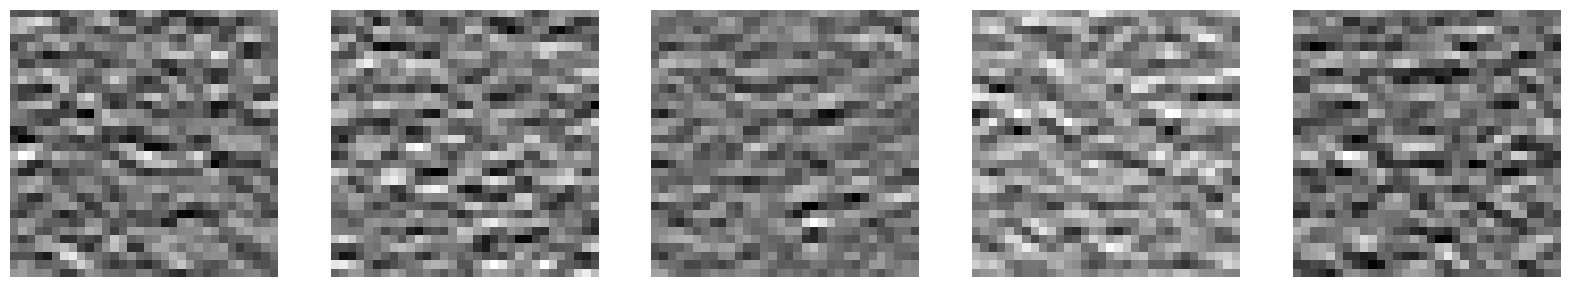

In [43]:
# Exemple d'utilisation
horizontal_filter = [[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]]
plot_filter(images, horizontal_filter)

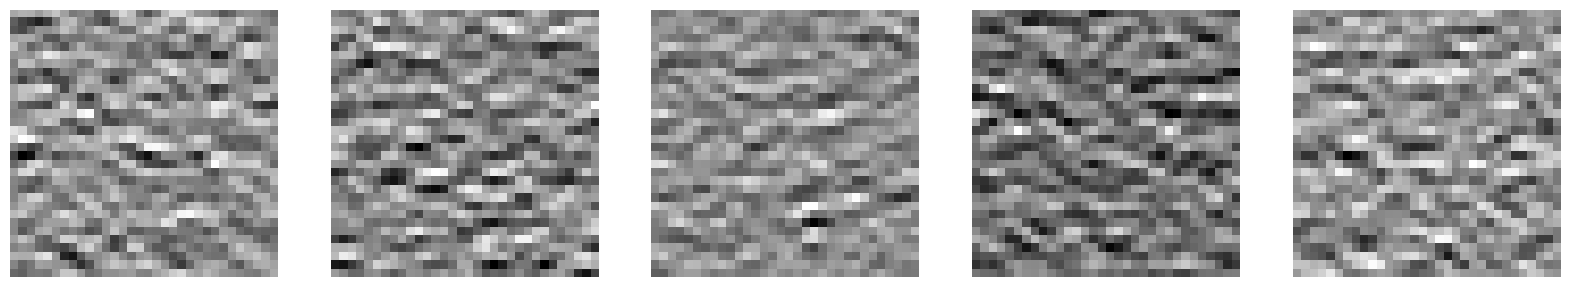

In [47]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

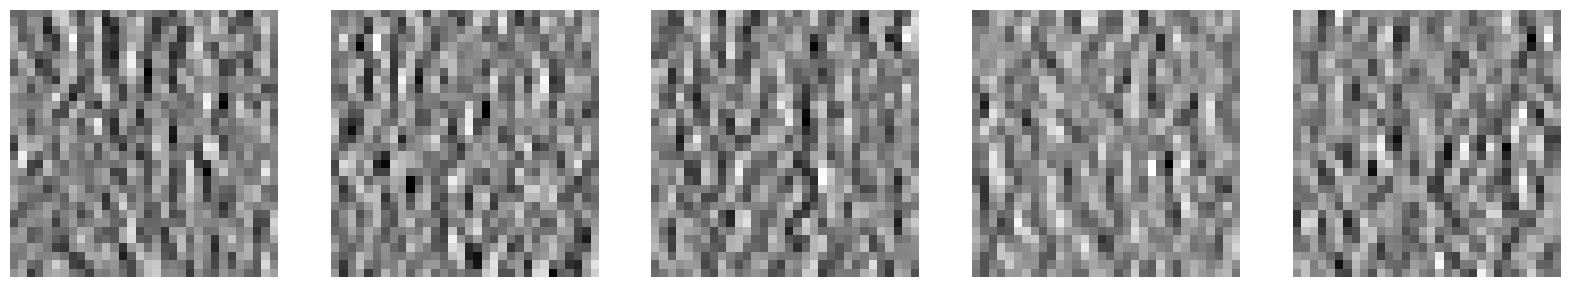

In [49]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

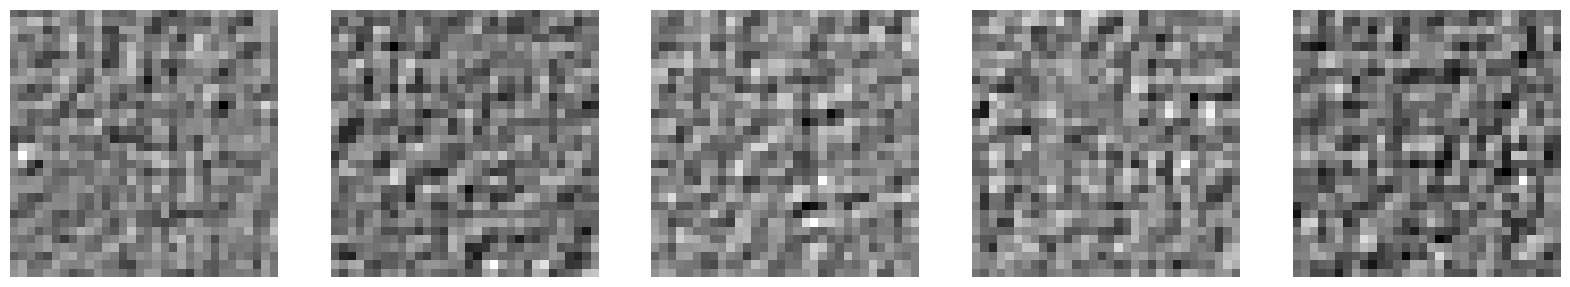

In [51]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

As you can see, the filter has a height, width and depth of 2x2x5. All the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not, then there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed-up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter, and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Let's create a function that allows us to see the outputs of a pooling layer on a batch of images

In [54]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

Répertoire trouvé : /Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive /AMHCD_64
Epoch [1/30], Loss: 1.8853, Accuracy: 0.5035
Epoch [2/30], Loss: 0.7021, Accuracy: 0.8183
Epoch [3/30], Loss: 0.4841, Accuracy: 0.8694
Epoch [4/30], Loss: 0.3687, Accuracy: 0.9007
Epoch [5/30], Loss: 0.2930, Accuracy: 0.9211
Epoch [6/30], Loss: 0.2382, Accuracy: 0.9334
Epoch [7/30], Loss: 0.2010, Accuracy: 0.9451
Epoch [8/30], Loss: 0.1780, Accuracy: 0.9488
Epoch [9/30], Loss: 0.1519, Accuracy: 0.9574
Epoch [10/30], Loss: 0.1401, Accuracy: 0.9586
Epoch [11/30], Loss: 0.1226, Accuracy: 0.9657
Epoch [12/30], Loss: 0.1171, Accuracy: 0.9667
Epoch [13/30], Loss: 0.1078, Accuracy: 0.9687
Epoch [14/30], Loss: 0.1012, Accuracy: 0.9707
Epoch [15/30], Loss: 0.0895, Accuracy: 0.9744
Epoch [16/30], Loss: 0.0796, Accuracy: 0.9769
Epoch [17/30], Loss: 0.0788, Accuracy: 0.9776
Epoch [18/30], Loss: 0.0697, Accuracy: 0.9789
Epoch [19/30], Loss: 0.0670, Accuracy: 0.9793
Epoch [20/30], Loss: 0.0623, Accuracy: 0.98

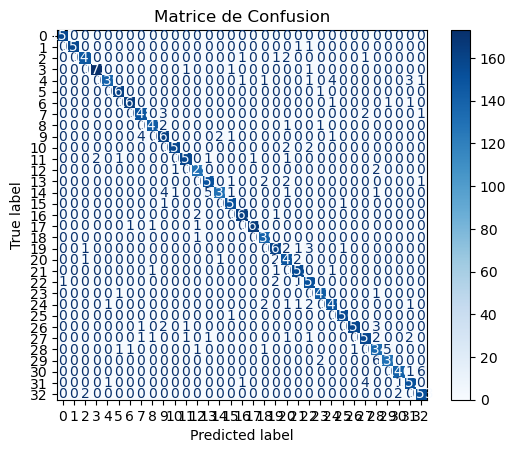

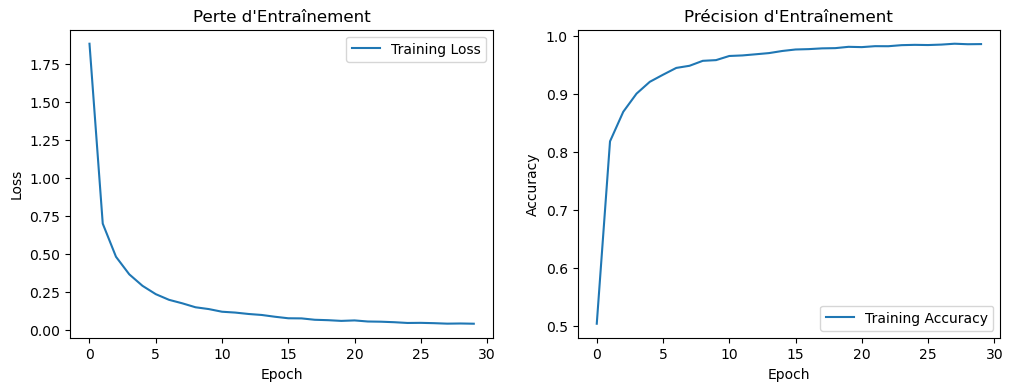

Modèle sauvegardé sous 'lenet5_amhcd.pth'


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Définition des transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Définition du chemin du dataset
dataset_path = '/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive /AMHCD_64'
if os.path.exists(dataset_path):
    print(f"Répertoire trouvé : {dataset_path}")
else:
    print(f"Erreur : Le répertoire {dataset_path} n'existe pas.")
    print("Contenu du répertoire parent :", os.listdir('/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/'))

# Chargement du dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Division en train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Définition du modèle LeNet-5
class LeNet5(nn.Module):
    def __init__(self, num_classes=33):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialisation du modèle, perte et optimiseur
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(num_classes=33).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
num_epochs = 30
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Évaluation sur l'ensemble de test avec collecte des prédictions
model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

# Visualisation de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion')
plt.show()

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perte d\'Entraînement')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Précision d\'Entraînement')
plt.legend()
plt.show()

# Sauvegarde du modèle (optionnel)
torch.save(model.state_dict(), 'lenet5_amhcd.pth')
print("Modèle sauvegardé sous 'lenet5_amhcd.pth'")

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration (instead of command-line arguments)
config = {
    'data_dir': '/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive/AMHCD_64',
    'epochs': 50,
    'batch_size': 32,
    'lr': 0.0005,
    'seed': 42
}

# Set random seeds for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['seed'])

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Check if dataset directory exists
if not os.path.exists(config['data_dir']):
    print(f"Error: Dataset directory '{config['data_dir']}' does not exist.")
    print("Please ensure you have downloaded the AMHCD dataset and placed it in the correct location.")
else:
    print(f"Dataset directory found: {config['data_dir']}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
print("Loading dataset...")
dataset = ImageFolder(root=config['data_dir'], transform=transform)
print(f"Dataset loaded with {len(dataset)} samples and {len(dataset.classes)} classes.")

# Split dataset into train/validation/test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(config['seed'])
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Define the improved LeNet-5 model
class LeNet5Improved(nn.Module):
    def __init__(self, num_classes=33):
        super(LeNet5Improved, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 120)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = LeNet5Improved(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

print("Starting training...")
for epoch in range(config['epochs']):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), 'models/best_model.pth')

    print(f'Epoch [{epoch+1}/{config["epochs"]}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

print("Training completed.")

# Load best model for evaluation
model.load_state_dict(torch.load('models/best_model.pth'))

# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

# Generate and save confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=300)
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figures/training_history.png', dpi=300)
plt.show()

# Save final model
torch.save(model.state_dict(), 'models/final_model.pth')
print("Model saved as 'models/final_model.pth'")

Error: Dataset directory '/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive/AMHCD_64' does not exist.
Please ensure you have downloaded the AMHCD dataset and placed it in the correct location.
Loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/macbook/Desktop/Tp Deep Lerning/Database AMHCD/archive/AMHCD_64'